#Laborator 5

In cadrul acestui laborator vom implementa o solutie de detectie. Datasetul folosit se numeste [American Sign Language Letters Dataset](https://public.roboflow.com/object-detection/american-sign-language-letters/1/download/coco).

In [1]:
!curl -L "https://public.roboflow.com/ds/KamceLFGGS?key=dqp8HADMki" > roboflow.zip; unzip -q roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   892  100   892    0     0   2065      0 --:--:-- --:--:-- --:--:--  2064

  0 22.8M    0 82971    0     0  69997      0  0:05:42  0:00:01  0:05:41 69997
 60 22.8M   60 13.7M    0     0  6548k      0  0:00:03  0:00:02  0:00:01 14.1M
100 22.8M  100 22.8M    0     0  9230k      0  0:00:02  0:00:02 --:--:-- 16.8M
curl: (3) URL using bad/illegal format or missing URL
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--  

In [2]:
! ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!ls train | grep "json"

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Crearea Dataloader-ului

In continuare, pentru a incarca date, folosim un obiect de tipul torch.utils.data.Dataset. Acesta are 3 metode importante:

```
__init__()
__len__()
__get_item__()
```





In [10]:
import torch
from pytorch_model_summary import summary
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch as t
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import random
from pycocotools.coco import COCO
import os
import torchvision.models as models
from torch import nn

from torchvision.transforms.functional import to_tensor
from IPython.display import clear_output
import time

random.seed(42)

class HandsDataset(Dataset):
  def __init__(self, coco_root, coco_annos, coco_imgs, img_size=(320, 320)):
    """
    Args:
        dataset_lines (array): array of strings of form "{image_path}|{rectangle_coordinates}".
        width (int): target image width.
        height (int): target image height.
    """
    self.coco_root = coco_root
    self.coco_annos = coco_annos
    self.coco_imgs = coco_imgs

    self.coco_anno_file = coco_annos
    self.coco_imgs_dir = coco_imgs

    self.coco = COCO(self.coco_anno_file)

    self.img_size = img_size

    self.init_dataset()

  def init_dataset(self):
    self.cat_ids = self.coco.getCatIds()

    self.img_ids = self.coco.getImgIds()
    self.ann_ids = self.coco.getAnnIds(self.img_ids)

    print("Dataset size {}".format(len(self.img_ids)))

  def __len__(self):
    return len(self.img_ids)

  def __getitem__(self, idx):
    img_meta = self.coco.loadImgs(self.img_ids[idx])[0]
    img_path = os.path.join(self.coco_imgs_dir, img_meta['file_name'])
    img = Image.open(img_path)
    ann_id = self.coco.getAnnIds(self.img_ids[idx])
    annos = self.coco.loadAnns(ann_id)[0]

    original_width, original_height = img.size

    img = img.resize(self.img_size)
    img = np.array(img)

    if len(img.shape) == 2:
      img = np.expand_dims(img, axis=2)
      img = np.repeat(img, 3, axis=2)

    img = to_tensor(img)

    bbox = annos['bbox']  # box is xywh
    cat_id = annos['category_id']

    x1, y1, w, h = bbox
    x2, y2 = x1 + w, y1 + h

    # x1 = x1 / original_width * self.img_size[0]
    # x2 = x2 / original_width * self.img_size[0]
    # y1 = y1 / original_height * self.img_size[1]
    # y2 = y2 / original_height * self.img_size[1]

    x1 = x1 / original_width
    x2 = x2 / original_width
    y1 = y1 / original_height
    y2 = y2 / original_height

    coordinates = np.array([x1, y1, x2, y2])
    coordinates =  coordinates.astype(np.float32)

    return img, coordinates, cat_id

Construire Dataset si vizualizare date.



In [5]:
from IPython.display import clear_output
import time

coco_root = "american-sign-language-letters-coco/"
coco_anno_train = os.path.join(coco_root, "train/_annotations.coco.json")
coco_imgs_train = os.path.join(coco_root, "train")

coco_anno_valid = os.path.join(coco_root, "valid/_annotations.coco.json")
coco_imgs_valid = os.path.join(coco_root, "valid")

dataset_train = HandsDataset(coco_root, coco_anno_train, coco_imgs_train, img_size=(224, 224))
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)

dataset_valid = HandsDataset(coco_root, coco_anno_valid, coco_imgs_valid, img_size=(224, 224))
valid_loader = DataLoader(dataset_valid, batch_size=1, shuffle=False) # keep batch_size=1

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Dataset size 1512
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Dataset size 144


torch.Size([16, 224, 224, 3])


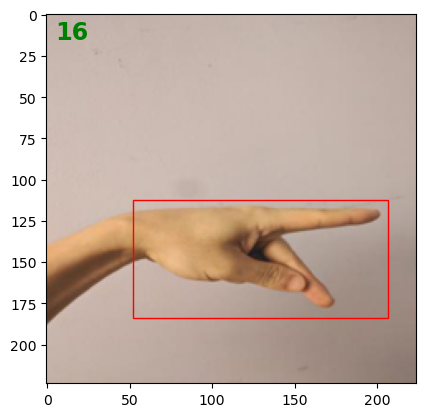

In [6]:
see_examples = 3
for i, (imgs, coordinates, cat_id) in enumerate(train_loader):
    clear_output(wait=True)
    imgs = np.transpose(imgs, (0, 2, 3, 1))
    print(imgs.shape)

    plt.imshow(imgs[0])

    x1, y1, x2, y2 = coordinates[0]
    x1 = x1 * dataset_train.img_size[1]
    y1 = y1 * dataset_train.img_size[0]
    x2 = x2 * dataset_train.img_size[1]
    y2 = y2 * dataset_train.img_size[0]
    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(5, 15, cat_id[0].item(), fontsize='xx-large', color='g', fontweight='bold')
    plt.show()

    if i >= see_examples - 1:
      break
    time.sleep(1)

# Crearea unei retele neurale convolutionale

### Cerinte
* Creati o arhitectura de retea neuronala convolutionala pentru regresie pe cele 4 coordonate alte imaginilor din dataset.
* Punctaj: 7 puncte pentru o retea cu rezultate *bune*.

#### Hint


  


*   Numarul de exemple de antrenare este prea mic pentru a antrena o retea "from scratch". Folositi o retea prea-antrenata pe ImagetNet, care a invatat deja sa recunoasca trasaturi utile pentru detectia de obiecte. Arhitectura recomandata este ResNet18 din Pytorch. Alte arhitecturi pot fi incercate.
*   La final trebuie utilizata o functie de activare care acopera [0,1]



### Definirea obiectelor folosite in timpul antrenarii
  * Numarul de epoci
  * Retea
  * Optimizator
  * Functie de loss

Experimentati cu valorile hiper-parametrilor de mai sus astfel incat reteaua sa invete *bine*.

In [70]:
resnet18 = models.resnet18(pretrained=True)
num_classes = 4
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, num_classes),
    nn.Sigmoid()
)
# resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.cuda()

In [71]:
# freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# unfreeze last 2 layers
# for param in resnet18.layer2.parameters():
#     param.requires_grad=True
for param in resnet18.layer3.parameters():
    param.requires_grad = True
for param in resnet18.layer4.parameters():
    param.requires_grad = True
for param in resnet18.avgpool.parameters():
    param.requires_grad = True
for param in resnet18.fc.parameters():
    param.requires_grad = True


In [61]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
print(summary(resnet18, torch.rand(size=(16, 3, 224, 224)).cuda(), show_input=True))

-------------------------------------------------------------------------------
           Layer (type)            Input Shape         Param #     Tr. Param #
               Conv2d-1      [16, 3, 224, 224]           9,408               0
          BatchNorm2d-2     [16, 64, 112, 112]             128               0
                 ReLU-3     [16, 64, 112, 112]               0               0
            MaxPool2d-4     [16, 64, 112, 112]               0               0
           BasicBlock-5       [16, 64, 56, 56]          73,984               0
           BasicBlock-6       [16, 64, 56, 56]          73,984               0
           BasicBlock-7       [16, 64, 56, 56]         230,144               0
           BasicBlock-8      [16, 128, 28, 28]         295,424               0
           BasicBlock-9      [16, 128, 28, 28]         919,040         919,040
          BasicBlock-10      [16, 256, 14, 14]       1,180,672       1,180,672
          BasicBlock-11      [16, 256, 14, 14]     

In [73]:
dummy = torch.rand(size=(16, 3, 224, 224), dtype=torch.float32).cuda()

out = resnet18(dummy)

print(out)

tensor([[0.6740, 0.2763, 0.5567, 0.5709],
        [0.6944, 0.3596, 0.6712, 0.5475],
        [0.6476, 0.2667, 0.5314, 0.5832],
        [0.6853, 0.2338, 0.5912, 0.4547],
        [0.6647, 0.3347, 0.5357, 0.4277],
        [0.6926, 0.2133, 0.6680, 0.5423],
        [0.8070, 0.3899, 0.4444, 0.5943],
        [0.6305, 0.2282, 0.6232, 0.4363],
        [0.5865, 0.3302, 0.5256, 0.5483],
        [0.6824, 0.3599, 0.7126, 0.4550],
        [0.6073, 0.4006, 0.5161, 0.5734],
        [0.7023, 0.3265, 0.4458, 0.5135],
        [0.6623, 0.3388, 0.7434, 0.3850],
        [0.5267, 0.3705, 0.5753, 0.4722],
        [0.6900, 0.3340, 0.8016, 0.4728],
        [0.5240, 0.2815, 0.5878, 0.5150]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


In [80]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
  # import pdb; pdb.set_trace()
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader, 
             net: torch.nn.Module, loss_fn: torch.nn.Module, optimizer: optim.Optimizer):
  # Iteram prin numarul de epoci
  for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0

    # Iteram prin fiecare exemplu din dataset
    net.train()
    for idx, (images, labels, _) in enumerate(train_loader):

      images = images.cuda()
      # Aplicam reteaua neurala pe imaginile de intrare
      out = net(images)
      # Aplicam functia cost pe iesirea retelei neurale si pe adnotarile imaginilor 
      loss = loss_fn(out, labels.cuda())
      # Aplicam algoritmul de back-propagation
      loss.backward()
      # Facem pasul de optimizare, pentru a aplica gradientii pe parametrii retelei
      optimizer.step()
      # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
      optimizer.zero_grad()

      train_loss += loss.item()*images.size(0)

    
    # Caluculul acuratetii
    count = len(test_loader)
    IOU_list = []
    net.eval()

    for test_image, box_gt, _ in test_loader:
      test_image = test_image.cuda()
      bbox_pred = net(test_image)

      loss = loss_fn(bbox_pred, box_gt.cuda())

      bbox_pred = bbox_pred.detach().cpu().numpy()

      IOU_list.append(bb_intersection_over_union(bbox_pred[0], box_gt[0]))

      valid_loss += loss.item()*test_image.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print(f"Average train loss : {train_loss}")
    print(f"Average valid loss : {valid_loss}")

    IOU_list = np.array(IOU_list)
    IOU_list_50 = (IOU_list > 0.5).sum()
    IOU_list_75 = (IOU_list > 0.75).sum()
    IOU_list_90 = (IOU_list > 0.90).sum()

    print("Acuratetea IOU 50% la finalul epocii {} este {:.2f}%".format(e, (IOU_list_50 / count)))
    print("Acuratetea IOU 75% la finalul epocii {} este {:.2f}%".format(e, (IOU_list_75 / count)))
    print("Acuratetea IOU 90% la finalul epocii {} este {:.2f}%".format(e, (IOU_list_90 / count)))


In [ ]:
import torch.optim as optim

# Definiti numarul de epoci
epochs = 50

# Definiti reteaua
# network = None

# Definiti optimizatorul
optimizer = optim.SGD(resnet18.parameters(), lr=0.001)

# Dupa definirea optimizatorului si dupa fiecare iteratie trebuie apelata functia zero_grad().
# Aceasta face toti gradientii zero.
# Completati codul pentru a face gradientii zero aici
optimizer.zero_grad()

# Definiti functia cost pentru pentru regressie
loss_fn = nn.MSELoss()
## Definirea functiei de antrenare

In [81]:
train_fn(epochs, train_loader, valid_loader, resnet18, loss_fn, optimizer)

Average train loss : 0.01064912666364637
Average valid loss : 0.009706081839794933
Acuratetea IOU 50% la finalul epocii 0 este 1.00%
Acuratetea IOU 75% la finalul epocii 0 este 0.85%
Acuratetea IOU 90% la finalul epocii 0 este 0.12%
Average train loss : 0.010443224014822769
Average valid loss : 0.009685368758154154
Acuratetea IOU 50% la finalul epocii 1 este 1.00%
Acuratetea IOU 75% la finalul epocii 1 este 0.85%
Acuratetea IOU 90% la finalul epocii 1 este 0.12%
Average train loss : 0.010605826190421505
Average valid loss : 0.00992193608362868
Acuratetea IOU 50% la finalul epocii 2 este 1.00%
Acuratetea IOU 75% la finalul epocii 2 este 0.83%
Acuratetea IOU 90% la finalul epocii 2 este 0.11%
Average train loss : 0.010542856504716886
Average valid loss : 0.009750800833292791
Acuratetea IOU 50% la finalul epocii 3 este 1.00%
Acuratetea IOU 75% la finalul epocii 3 este 0.83%
Acuratetea IOU 90% la finalul epocii 3 este 0.11%
Average train loss : 0.010458600470825793
Average valid loss : 0.0

## Augmentare date

O metoda de imbunatatire a performantei modelului este augmentarea setului de date. Aceste augmentari trebuie sa tina cont de natura taskului si de natura etichetelor.

### Cerinta

(3p) Modificati Dataset-ul precedent astfel incat sa augmenteze datele de antrenare cu o probabilitate aleasa de voi. Cum afecteaza acest lucru performanta modelului?

### Bonus
(2p) Dataloaderul intoarce si clasa fiecarui obiect de detectat (litera corespunzatoare fiecarui semn din limbajul Sign Language). Creati o arhitectura care prezice si acesta clasa, pe langa regresia pe box. Antrenati reteaua. 